## Demo: repeating a subcycle until a stop condition is triggered
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

This notebook provides an example of a simulation that takes a number of sub processes, grouped in a sequential activity, that is **executed while a stop condition is not yet met**.

For this example we work with the following sub processes:
* sailing empty
* loading
* sailing full
* unloading

#### 0. Import libraries

In [ ]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Used for making the graph to visualize our problem
import networkx as nx 
import matplotlib.pyplot as plt

import opentnsim.core

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 1.1 Create graph

In [3]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
[4.651810765193616,53.06520633542454],
[4.665949515416939,53.06291148049787], 
[4.678223920527591,53.06107438344198], 
[4.688183738253528,53.05974704102928], 
[4.69785320390846 ,53.05828289064841], 
[4.704381491443237,53.05728100125996], 
[4.709772259231658,53.05656711326854]] 

# for each edge (between above coordinates) specify the depth (m)
depths = [20, 18, 16, 14, 11, 8]

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [4]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": depths[index]})

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

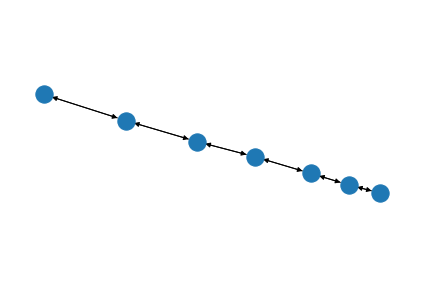

In [5]:
# show graph
nx.draw(FG, positions)
plt.show()

In [6]:
# inspect if properties were set correctly
for edge in FG.edges(data = True):
    print('{}, {}: general depth {} m'.format(edge[0], edge[1], FG.edges[(edge[0], edge[1])]['Info']['GeneralDepth']))

Node 0, Node 1: general depth 20 m
Node 1, Node 0: general depth 20 m
Node 1, Node 2: general depth 18 m
Node 2, Node 1: general depth 18 m
Node 2, Node 3: general depth 16 m
Node 3, Node 2: general depth 16 m
Node 3, Node 4: general depth 14 m
Node 4, Node 3: general depth 14 m
Node 4, Node 5: general depth 11 m
Node 5, Node 4: general depth 11 m
Node 5, Node 6: general depth 8 m
Node 6, Node 5: general depth 8 m


In [21]:
my_env.FG = FG

#### 2. Define object classes

In [25]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
        opentnsim.core.ContainerDependentMovable,
        opentnsim.core.VesselProperties,
        opentnsim.core.Routeable,
        opentnsim.core.ExtraMetadata,
        opentnsim.core.ConsumesEnergy
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [23]:
# prepare input data for from_site
location_from_site = FG.nodes(data = True)['Node 0']['geometry']
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 100,
                  "level": 50
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = FG.nodes(data = True)['Node 6']['geometry']
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 50,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [24]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 0.00001,
                 "unloading_rate": 0.00001,
                 "capacity": 4,
                 "compute_v": lambda x: 10,
                 # TODO: confirm these numbers
                 'P_installed': 2200, 
                 'L_w': 15, 
                 'C_b': 0.85, 
                 'current_year': 2022,  
                 'c_year': 1990,
                 'type': 'a',
                 'B': 11,
                 'L': 135,
                 'T': 2.5,
                 'route': None
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

# # monkeypatch with L
# vessel01.L = 227
# vessel01.B = 32
# vessel01.T = 17


TypeError: __init__() missing 1 required positional argument: 'env'

##### 3.3 Create activity/activities

In [19]:
# initialise registry
registry = {}

In [20]:
# create a list of the sub processes
sub_processes = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=from_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="loading",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=4,
        duration=1000,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing full",
        registry=registry,
        mover=vessel01,
        destination=to_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=to_site,
        amount=4,
        duration=1000,
    ),
    model.BasicActivity(
        env=my_env,
        name="basic activity",
        registry=registry,
        duration=0,
        additional_logs=[vessel01],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
    env=my_env,
    name="sequential_activity_subcycle",
    registry=registry,
    sub_processes=sub_processes,
)

# create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
while_activity = model.WhileActivity(
    env=my_env,
    name="while_sequential_activity_subcycle",
    registry=registry,
    sub_processes=[sequential_activity],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

NameError: name 'vessel01' is not defined

#### 4. Register processes and run simpy

In [ ]:
# initate the simpy processes defined in the 'while activity' and run simpy
model.register_processes([while_activity])
my_env.run()

In [ ]:
# This is the power used to do the last move step
# TODO: 
# - remember P_given for each move step (kWh for last move step -> list of steps)
# - adapt T for each step
# - Sum up the P_given over duration of move activity (kW - kWh)
# - acceleration is not included (do small steps where you increase velocity), use power2v to compute velocity
# - OR: increase power and compute v (more elegant, scipy integrate...)


vessel01.P_given

#### 5. Inspect results
##### 5.1 Inspect logs

In [ ]:
plot.get_log_dataframe(vessel01, [while_activity, *sub_processes, sequential_activity])

##### 5.2 Visualise gantt charts

In [ ]:
plot.get_gantt_chart([while_activity, sequential_activity, *sub_processes])

In [ ]:
plot.get_gantt_chart([vessel01, from_site, to_site])

##### 5.3 Visualise container volume developments

In [ ]:
fig = plot.get_step_chart([vessel01, from_site, to_site])

#### Sandbox

In [ ]:
pd.DataFrame.from_dict(vessel01.log)

In [ ]:
list(set(vessel01.log["ActivityID"]))

In [ ]:
energycalculation = opentnsim.energy.EnergyCalculation([], vessel01)
energycalculation.calculate_energy_consumption()
df = pd.DataFrame.from_dict(energycalculation.energy_use)

In [ ]:
energycalculation.calculate_energy_consumption()